Copyright **`(c)`** 2023 Angelo Iannielli s317887 `<angelo.iannielli@studenti.polito.it>`  
[`https://github.com/AngeloIannielli/polito-computational-intelligence-23`]  

# LAB9

Write a local-search algorithm (eg. an EA) able to solve the *Problem* instances 1, 2, 5, and 10 on a 1000-loci genomes, using a minimum number of fitness calls. That's all.

### Deadlines:

* Submission: Sunday, December 3 ([CET](https://www.timeanddate.com/time/zones/cet))
* Reviews: Sunday, December 10 ([CET](https://www.timeanddate.com/time/zones/cet))

Notes:

* Reviews will be assigned  on Monday, December 4
* You need to commit in order to be selected as a reviewer (ie. better to commit an empty work than not to commit)

In [1]:
from random import choices
from random import random, randint, sample
from collections import namedtuple
from copy import deepcopy, copy 
from typing import List
import matplotlib.pyplot as plt

import lab9_lib

In [2]:
# GLOBAL VARIABLES INITIALIZATION

LOCI = 1000
population = []

THRESHOLDS = 3
DIM_FIRST_POP = 100

GENERATIONS = 10000
gen = 1

problem = lab9_lib.make_problem(1)

In [3]:
class Individual:
    def __init__(self):
        self.genome = []
        self.fitness = 0

    def generate_randomly(self):
        self.genome = choices([0, 1], k=LOCI)
        self.fitness = problem(self.genome)

    def generate_by_recombination(self, mut_rate, parents):
        
        # Define the dimension of the slices in the xover
        dim_slice = randint(1, LOCI // len(parents))

        for slice in range(LOCI // dim_slice):
            selected_parent = choices(parents, weights=[p.fitness for p in parents], k=1)
            genes = selected_parent[0].genome[slice * dim_slice : slice * dim_slice + dim_slice]
            self.genome.extend(genes)

        # Fill the genes out of the last slice
        selected_parent = choices(parents, weights=[p.fitness for p in parents], k=1)
        genes = selected_parent[0].genome[LOCI // dim_slice * dim_slice : LOCI]
        self.genome.extend(genes)

        for index in range(len(self.genome)):
            if random() < mut_rate :
                self.genome[index] = 1 if self.genome[index] == 0 else 0

    def estimate_fitness(self):
        self.fitness = problem(self.genome)

    def __str__(self):
        return f"{self.fitness:.2%} : {''.join(str(g) for g in self.genome)}"



In [4]:
class Island:
    def __init__(self, min_fitness, max_fitness, population, num_parents, mut_rate, dim_population, dim_tournament, level):
        self.min_fitness = min_fitness
        self.max_fitness = max_fitness
        self.population = population
        self.num_parents = num_parents
        self.mut_rate = mut_rate
        self.dim_population = dim_population
        self.dim_tournament = dim_tournament
        self.level = level

    def parents_selection(self):
        # sorted_population = sorted(self.population, key=lambda ind: ind.fitness, reverse=True)
        # return sorted_population[:self.dim_population]

        population_copy = copy(self.population)
        parents = []

        for _ in range(len(self.population)//self.dim_tournament):
            tournament = sample(population_copy, k= self.dim_tournament)
            tournament = sorted(tournament, key=lambda ind: ind.fitness, reverse=True)

            parents.append(tournament.pop(0))
            for loser in tournament:
                population_copy.remove(loser)

        return parents        
    
    def survival_selection(self):
        sorted_population = sorted(self.population, key=lambda ind: ind.fitness, reverse=True)

        travellers = namedtuple('travellers', ['weak', 'strong'])
        weak_population = []
        strong_population = []
        new_sorted_population = []
        

        for ind in sorted_population:

            # If the individual has a low fitness it is demote to a lower island
            if ind.fitness < self.min_fitness:
                weak_population.append(ind)

            # If the individual has a high fitness it is promote to an higher island
            elif ind.fitness > self.max_fitness:
                strong_population.append(ind)

            else:
                new_sorted_population.append(ind)
        
        return travellers(weak_population, strong_population)
    
    def shrink_population(self):
        sorted_population = sorted(self.population, key=lambda ind: ind.fitness, reverse=True)
        self.population = sorted_population[:self.dim_population]

    def get_top_solution(self) -> Individual :
        if len(self.population) > 0:
            return self.population[0]
        else: 
            return None
    
    def __str__(self):
        return f"Island {self.min_fitness:.2%}-{self.max_fitness:.2%} > POPULATION SIZE: {len(self.population)}"

In [5]:
archipelago: List[Island] = []
solution = Individual()

In [6]:
archipelago: List[Island] = []
THRESHOLDS = 3
DIM_FIRST_POP = 80

solution = Individual()
best_solutions_fitness = []

for level in range(THRESHOLDS):
    archipelago.append(Island(min_fitness= 1 / THRESHOLDS * level, max_fitness= 1 / THRESHOLDS * ( level + 1), population= [], num_parents= THRESHOLDS - level + 1, mut_rate= 1 / (10 ** (level + 1)), dim_population= DIM_FIRST_POP // ( level + 1 ), dim_tournament= THRESHOLDS + 2, level= level))

# FIRST GENERATION
for _ in range(DIM_FIRST_POP):
    ind = Individual()
    ind.generate_randomly()
    archipelago[0].population.append(ind)

weak, strong = archipelago[0].survival_selection()

print("Weak dim: ", len(weak), " Strong dim: ", len(strong))

# Put the weak individuals in the correct island
for ind in weak:
    for island in archipelago:
        if ind.fitness > island.min_fitness and ind.fitness < island.max_fitness:
            island.population.append(ind)

# Bring the strong individual high
for ind in strong:
    for island in archipelago:
        if ind.fitness > island.min_fitness and ind.fitness < island.max_fitness:
            island.population.append(ind)

for island in archipelago:
    # Shrink the population to dim_population elements
    island.shrink_population()
    print(island)
    for ind in island.population:
        print(ind)

# Save the top solution 
for island in reversed(archipelago):
    current_top_solution = island.get_top_solution()
    if current_top_solution:
        print("Top solution:", current_top_solution)
        solution = current_top_solution
        break  

best_solutions_fitness.append(solution.fitness)
print(problem.calls)



Weak dim:  0  Strong dim:  80
Island 0.00%-33.33% > POPULATION SIZE: 80
52.20% : 0011101010000011101110111000000000001011001110010101111110011100011101001001011100111101000110111001011110101100101100101000110110100100000111011101111110000101001001100011010100110001111000010100111111001110100101101110110010001011110011110000010011010111110111110100001001111100000100110010010010001101100111011110001100111100010001100110000101101010110110100111111001110010010111001111011010011000101010001110000110110111111110000111000010111011001011100011111100011011010111000011001000111110111010001111111000011111111001010001010001011000111111000011111111110101011101111010010011111000110011101011101101010010000110001111101101001010101101001010010000000111101010111010101001001001101111100101001000111001000100111110100000100101000100111010010111001101110001100110001111001101000110101010101010100010110000011010110110110000111111000001001010110100101000001011111000000010011001011010101111111111000000100010000

In [7]:
GENERATIONS = 10000
gen = 1

# Iterate until a perfect solution is found or the number of generations is reached
while solution.fitness < 1.0 and gen < GENERATIONS:
    
    print("GENERATION", gen)

    # For each island, select a group of parents and generate the offsprings
    for island in archipelago:
        selected_parents = island.parents_selection()

        # The number of new offsprings is enough to fill the expected space of the island
        for _ in range(island.dim_population):

            # Every island needs a specific number of parents to create a new individual
            if len(selected_parents) > island.num_parents:
                parents = sample(selected_parents, k= island.num_parents)

                child = Individual()
                    
                child.generate_by_recombination(island.mut_rate, parents)

                child.estimate_fitness()

                island.population.append(child)

    # For each island, there is a survival selection. The final number of individuals must be <= dim_population 
    for island in archipelago:

        # Every selection updates the population inside the island and returns two lists of individuals that are promoted/demoted
        weak, strong = island.survival_selection()

        print("Island LVL", island.level, ">", "promoted:", len(strong), "demoted:", len(weak))

        for ind in weak:
            for index in range(0, island.level):
                island = archipelago[index]
                if ind.fitness > island.min_fitness and ind.fitness < island.max_fitness:
                    island.population.append(ind)

        for ind in strong:
            for index in range(island.level + 1, len(archipelago)):
                island = archipelago[index]
                if ind.fitness > island.min_fitness and ind.fitness < island.max_fitness:
                    island.population.append(ind)

    for island in archipelago:
            # Shrink the population to dim_population elements
            island.shrink_population()
            
            print(island)

    # Check the top solution 
    current_top_solution = None

    # Start by searching from the highest level
    for island in reversed(archipelago):
        current_top_solution = island.get_top_solution()
        
        # When a solution is found, it must be the better (because it is in the first position of the top level)
        if current_top_solution:
            print("Current top sol:", current_top_solution)

            # Check if the solution is better than the latest one
            if current_top_solution.fitness > solution.fitness :
                gain = (current_top_solution.fitness - solution.fitness)
                print(f"Found a better solution (+{gain:.2%}): {current_top_solution}")
                solution = current_top_solution
            break    

    best_solutions_fitness.append(solution.fitness)
    print("Fitness called", problem.calls, "times")
    print("")            
                    
    gen += 1

GENERATION 1
Island LVL 0 > promoted: 160 demoted: 0
Island LVL 1 > promoted: 0 demoted: 0
Island LVL 2 > promoted: 0 demoted: 0
Island 0.00%-33.33% > POPULATION SIZE: 80
Island 33.33%-66.67% > POPULATION SIZE: 40
Island 66.67%-100.00% > POPULATION SIZE: 0
Current top sol: 54.80% : 101000011001101100011101011010010100111010010100011001111110101110100111000110111001111000111111111111010001001110101100110010010010101001000000100111010010011110000011110001001010011100101001000001100100111111001101111011111100101111001111000000001101001111011100011110100100100111011111001111000000010101001111100000000111100100101100011110110110001111000011110111100011010010101001010001001111110111110010010111110111011111111000011100000011001100101010101111110110001001001100111011001101011011101010111111110001011111100101010001110101110011100000001111110110111000101010010111100101000010100110011001011111011000101110111011111010111010101110110010000111101110011011010111110000111011010000111001011100110101101

Island LVL 0 > promoted: 160 demoted: 0
Island LVL 1 > promoted: 0 demoted: 0
Island LVL 2 > promoted: 0 demoted: 0
Island 0.00%-33.33% > POPULATION SIZE: 80
Island 33.33%-66.67% > POPULATION SIZE: 40
Island 66.67%-100.00% > POPULATION SIZE: 0
Current top sol: 61.00% : 1011100010011100000101111100101111101111001100111111101010101110110101010110011111001101011010111111111000010001101111101110011100100001111101100111110001101111111111110100001011010110101101101101111111110000110011011110111111001011111000010011111000100101011101101110001011011110100111111110011001110111010111111000000001111001101100101001101011110010100101111111111111110100111101111111010110110100010001110101110110001111111101100110010110111000111110111101011111111101111101101001100011101101011011001111011101111101101100011111100110001100101111000101010000111011100101001011111110111011001001011000101001010110001011101111111111001011011000011100100001111011100101001011011101011111011011011011100111011111111101000101011111

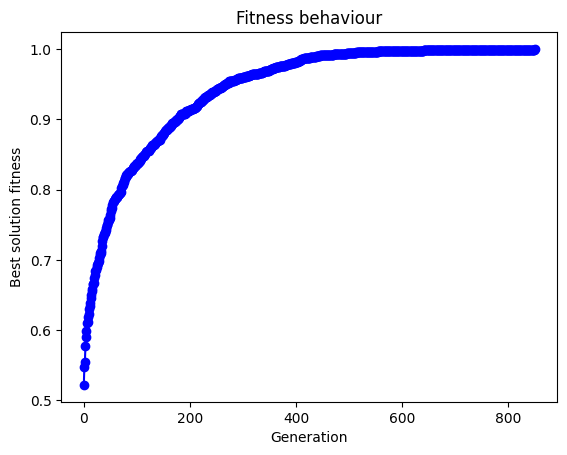

In [8]:
# Crea il grafico
plt.plot(list(range(gen)), best_solutions_fitness, marker='o', linestyle='-', color='b')

# Aggiungi etichette e titoli
plt.xlabel('Generation')
plt.ylabel('Best solution fitness')
plt.title('Fitness behaviour')

# Visualizza il grafico
plt.show()